# Pretraining on EuroSAT multispectral images

This Notebook shows how to train the multispectral model on EuroSAT (0.99 accuracy).

The weights of the pretrained model can be downloaded in the "Weights of pretrained model" directory of this Github Repository.

In [25]:
from fastai.vision import *
from PIL import Image
from matplotlib.pyplot import imshow
from pathlib import Path
from tqdm import tqdm
from skimage import io
from fastai.vision.models.xresnet import *

In [16]:
PATH = 'WFP/eurosat-allbands/'

In [35]:
class TiffList(ImageList):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def open(self, fn):
        raw = io.imread(str(fn))
        x = pil2tensor(raw,np.float32)
        return x
    
def calculate_stats_eurosat_allbands(data):
    all_images = torch.zeros((27000, 13, 64, 64))
    for i, im in enumerate(data):
        all_images[i] = im
    
    stat_mean = all_images.mean(-1).mean(-1).mean(0)
    stat_std = all_images.std(-1).std(-1).std(0)
    
    return (stat_mean.tolist(), stat_std.tolist())

In [31]:
stats_eurosat_allbands = ([1353.73046875,
  1117.2020263671875,
  1041.8876953125,
  946.5513305664062,
  1199.1883544921875,
  2003.0101318359375,
  2374.01171875,
  2301.222412109375,
  732.1828002929688,
  12.099513053894043,
  1820.6893310546875,
  1118.1998291015625,
  2599.784912109375],
 [30.343395233154297,
  66.4549560546875,
  71.52734375,
  86.9700698852539,
  70.47565460205078,
  81.35286712646484,
  97.88168334960938,
  99.96805572509766,
  27.891748428344727,
  0.32882159948349,
  92.60734558105469,
  87.39993286132812,
  106.57888793945312])

In [36]:
data = TiffList.from_folder(PATH, extensions=['.tif'])
data = data.split_by_rand_pct(0.2)
data = data.label_from_folder()
data = data.databunch()
data = data.normalize(stats_eurosat_allbands)

# Training for 80 epochs with MixUp augmentation

In [40]:
model = xresnet50(c_in=13, c_out=10)

learn = Learner(data, model, metrics=[accuracy]).mixup()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


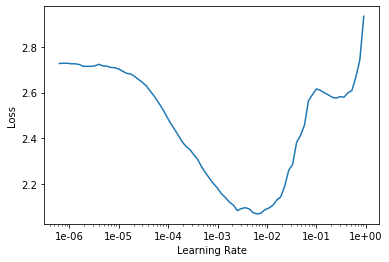

In [41]:
learn.lr_find()
learn.recorder.plot()

In [42]:
learn.fit_one_cycle(80, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.058448,0.471763,0.873889,00:20
1,0.936728,0.372519,0.902407,00:20
2,0.891736,0.326304,0.910370,00:20
3,0.848891,0.301313,0.925370,00:20
4,0.827248,0.302696,0.917407,00:20
5,0.810900,0.261158,0.932222,00:20
6,0.781085,0.262231,0.934444,00:20
7,0.785193,0.214973,0.950370,00:20
8,0.728782,0.213543,0.944630,00:21
9,0.724985,0.179777,0.955556,00:20


In [43]:
st = learn.model.state_dict()

In [44]:
torch.save(st, 'Model-multispectral-0.99')